In [1]:
import copy
import os
import random
import time
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
SEED = 42
BATCH_SIZE = 64 # 128
NUM_WORKERS = 0 # 4
MODEL_NAME = "vit_b_32"
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
# 장치 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

data_csv_file = "./image-data/labels-map.csv"
train_csv_file = "./image-data/train-labels.csv"
valid_csv_file = "./image-data/valid-labels.csv"
test_csv_file = "./image-data/test-labels.csv"
label_file = "./labels/256-common-hangul.txt"
#image_dir = "./image-data/hangul-images"

cuda


In [3]:
# 데이터셋 분리 함수
def split_dataset(csv_path, train_save_path, valid_save_path, test_save_path, test_size, valid_size, random_seed):
    # CSV 파일 읽기
    df = pd.read_csv(csv_path, header=None, names=['path', 'label'])
    
    # 먼저 전체 데이터셋을 train + validation과 test로 분리
    train_valid_df, test_df = train_test_split(df, test_size=test_size, random_state=random_seed, stratify=df['label'])
    
    # train + validation 데이터셋을 train과 validation으로 분리
    train_size = 1 - valid_size
    train_df, valid_df = train_test_split(train_valid_df, test_size=valid_size/(train_size + valid_size), random_state=random_seed, stratify=train_valid_df['label'])
    
    # CSV 파일로 저장
    train_df.to_csv(train_save_path, index=False, header=False)
    valid_df.to_csv(valid_save_path, index=False, header=False)
    test_df.to_csv(test_save_path, index=False, header=False)    

# 데이터셋 클래스
class KoreanHandwritingDataset(Dataset):
    def __init__(self, csv_file, label_file, transform=None):
        self.dataset = pd.read_csv(csv_file, header=None, names=['path', 'label'])
        #self.image_dir = image_dir
        self.label_file = label_file
        self.transform = transform
        with open(self.label_file, 'r', encoding='utf-8') as f:
            hangul_chars = [line.strip() for line in f.readlines()]
        self.label_mapping = {char: idx for idx, char in enumerate(hangul_chars)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.image_dir, os.path.basename(self.dataset.iloc[idx]['path']))
        
        # 그레이스케일로 이미지 열기
        img_path = self.dataset.iloc[idx]['path']
        image = Image.open(img_path).convert("L")
        label = self.dataset.iloc[idx]['label']
        label = self.label_mapping[label]
        if self.transform:
            image = self.transform(image)
        return image, label
      
            
# 데이터 변환

train_transform = transforms.Compose([
    transforms.Resize(256),  # 먼저 이미지를 더 크게 리사이즈
    transforms.CenterCrop(224),  # 그 다음 중앙을 224x224 크기로 크롭
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

"""
# 기존의 데이터 변환 파이프라인에 데이터 증강을 추가합니다.
train_transform = transforms.Compose([
    transforms.Resize(256),  # 이미지를 256x256으로 리사이즈
    transforms.RandomResizedCrop(224),  # 랜덤한 위치에서 크롭 후 224x224로 리사이즈
    transforms.RandomRotation(degrees=15),  # 랜덤하게 이미지 회전
    #transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 수평 뒤집기
    #transforms.RandomVerticalFlip(p=0.5),  # 50% 확률로 수직 뒤집기
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 조정
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),  # 아핀 변환
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # 투시 변환
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # 가우시안 블러 적용
    transforms.Grayscale(num_output_channels=3),  # 흑백 이미지로 변환
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화
])
"""
valid_transform = transforms.Compose([
    transforms.Resize(256),  # 먼저 이미지를 더 크게 리사이즈
    transforms.CenterCrop(224),  # 그 다음 중앙을 224x224 크기로 크롭
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),  # 먼저 이미지를 더 크게 리사이즈
    transforms.CenterCrop(224),  # 그 다음 중앙을 224x224 크기로 크롭
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# 데이터셋 및 데이터 로더 준비
# split_dataset(data_csv_file, train_csv_file, valid_csv_file, test_csv_file, 0.2, 0.1, 42)
split_dataset(data_csv_file, train_csv_file, valid_csv_file, test_csv_file, 0.2, 0.25, 42) # 60 / 20 / 20

train_dataset = KoreanHandwritingDataset(train_csv_file, label_file, train_transform)
valid_dataset = KoreanHandwritingDataset(valid_csv_file, label_file, valid_transform)
test_dataset = KoreanHandwritingDataset(test_csv_file, label_file, test_transform)

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_data_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Valid Dataset Size: {len(valid_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 122880
Valid Dataset Size: 40960
Test Dataset Size: 40960


In [4]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, checkpoint_path=None):
    # 모델을 선택하고 초기화합니다.
    if model_name == "resnet101":
        """ Resnet101 """
        model = models.resnet101(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "alexnet":
        """ Alexnet """
        model = models.alexnet(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_v2 """
        model = models.mobilenet_v2(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg19":
        """ VGG19 """
        model = models.vgg19(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "vgg19_bn":
        """ VGG19_bn """
        model = models.vgg19_bn(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "squeezenet":
        """ Squeezenet """
        model = models.squeezenet1_0(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes
        
    elif model_name == "densenet121":
        """ Densenet """
        model = models.densenet121(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "inception":
        """ Inception v3. Be careful, expects (299,299) sized images and has auxiliary output """
        model = models.inception_v3(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        # Handle the auxilary net
        num_ftrs = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vit_b_16":
        """ Vision Transformer B-16 """
        model = models.vit_b_16(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        # ViT의 분류기 부분을 교체합니다.
        num_ftrs = model.heads.head.in_features
        model.heads.head = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit_b_32":
        """ Vision Transformer B-32 """
        model = models.vit_b_32(pretrained=use_pretrained)
        if feature_extract:
            for param in model.parameters():
                param.requires_grad = False
        # ViT의 분류기 부분을 교체합니다.
        num_ftrs = model.heads.head.in_features
        model.heads.head = nn.Linear(num_ftrs, num_classes)
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    # 체크포인트에서 모델 가중치를 로드할 경우
    if checkpoint_path:
        model.load_state_dict(torch.load(checkpoint_path))
    
    return model

In [5]:
def tensor_to_fig(tensor):
    # Move the tensor to CPU if it's on GPU
    tensor = tensor.cpu()
    # Convert the tensor to a numpy array
    npimg = tensor.numpy()
    # Transpose the dimensions from (C, H, W) to (H, W, C) to display with matplotlib
    npimg = np.transpose(npimg, (1, 2, 0))
    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(npimg)
    # Remove axes
    ax.axis('off')
    return fig



# 훈련 함수
def train_model(model, data_loader, device, criterion, optimizer, scheduler, num_epochs, writer=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    figure = None

    # Early Stopping을 위한 변수 초기화
    patience = 5
    no_improvement_count = 0
    early_stop = False
    best_loss = float('inf')

    for epoch in tqdm(range(num_epochs)):    
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # 각 에포크는 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정
                figure_inputs = []
                
            running_loss = 0.0
            running_corrects = 0
            
            # 데이터를 배치 단위로 가져와 처리합니다.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 파라미터 경사도를 0으로 설정
                optimizer.zero_grad()
                
                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'valid' and figure is None:
                    if len(figure_inputs) < 16:
                        figure_inputs.append(inputs.cpu())  # Move inputs to CPU before appending
                    if len(figure_inputs) >= 16:
                        # Concatenate the list of inputs to form a batch
                        figure_inputs = torch.cat(figure_inputs, dim=0)
                        # Select only the first 16 images
                        figure_inputs = figure_inputs[:16]
                        # Convert the batch of images to a grid and then to a figure
                        figure = tensor_to_fig(torchvision.utils.make_grid(figure_inputs, nrow=4))
                        break
                    
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # TensorBoard에 로그 기록
            if writer:
                writer.add_scalar(f'{phase} Loss', epoch_loss, epoch)
                writer.add_scalar(f'{phase} Accuracy', epoch_acc, epoch)

            if writer and phase == 'valid':
                # 검증 단계에서만 로깅합니다.
                if figure is not None:
                    writer.add_figure(f'{phase} Figure', figure, epoch)
                    
            if phase == 'valid':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count > patience:
                    print("Early stopping")
                    early_stop = True
                    break
                    
            # 모델을 깊은 복사(deep copy)함
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                plt.close(figure)  # Close the figure to prevent it from being displayed

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

# 모델 준비
model_ft = initialize_model(MODEL_NAME, num_classes=256, feature_extract=True, use_pretrained=True)
model_ft = model_ft.to(DEVICE)

# 손실 함수 및 최적화 함수 설정
criterion = nn.CrossEntropyLoss()
# Optimizer 및 Learning Rate Scheduler 설정
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.1)  # Decay LR by a factor of 0.1 every epoch

data_loader = {'train': train_data_loader, 'valid': valid_data_loader}
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = f'logs/{MODEL_NAME}_{current_time}'
writer = SummaryWriter(path)
model_ft = train_model(model_ft, data_loader, DEVICE, criterion, optimizer_ft, exp_lr_scheduler, NUM_EPOCHS, writer)
writer.close()
torch.save(model_ft.state_dict(), f'{path}/model.pth')

D:\GitHub\aistage-baseline\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\GitHub\aistage-baseline\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to C:\Users\YeongseonChoe/.cache\torch\hub\checkpoints\vit_b_32-d86f8d99.pth
100%|██████████████████████████████████████████████████████| 337M/337M [00:17<00:00, 19.9MB/s]
  0%|                                                                  | 0/10 [00:00<?, ?it/s]

Epoch 0/9
----------
train Loss: 1.7845 Acc: 0.6194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█████▍                                                | 1/10 [45:30<6:49:30, 2730.04s/it]

valid Loss: 0.0235 Acc: 0.0200

Epoch 1/9
----------
train Loss: 0.8095 Acc: 0.8475


 20%|██████████▍                                         | 2/10 [1:14:17<4:45:21, 2140.17s/it]

valid Loss: 0.8181 Acc: 0.8425

Epoch 2/9
----------
train Loss: 0.7644 Acc: 0.8622


 30%|███████████████▌                                    | 3/10 [1:30:30<3:07:30, 1607.21s/it]

valid Loss: 0.8050 Acc: 0.8474

Epoch 3/9
----------
train Loss: 0.7585 Acc: 0.8639


 40%|████████████████████▊                               | 4/10 [1:47:12<2:16:49, 1368.17s/it]

valid Loss: 0.8043 Acc: 0.8478

Epoch 4/9
----------
train Loss: 0.7579 Acc: 0.8642


 50%|██████████████████████████                          | 5/10 [2:03:42<1:42:40, 1232.05s/it]

valid Loss: 0.8042 Acc: 0.8478

Epoch 5/9
----------
train Loss: 0.7579 Acc: 0.8642


 60%|███████████████████████████████▏                    | 6/10 [2:20:21<1:16:51, 1152.79s/it]

valid Loss: 0.8042 Acc: 0.8477

Epoch 6/9
----------
train Loss: 0.7579 Acc: 0.8642


 70%|█████████████████████████████████████▊                | 7/10 [2:36:19<54:26, 1088.98s/it]

valid Loss: 0.8042 Acc: 0.8477
Early stopping

Epoch 7/9
----------
train Loss: 0.7579 Acc: 0.8642


 80%|███████████████████████████████████████████▏          | 8/10 [2:52:22<34:57, 1048.90s/it]

valid Loss: 0.8042 Acc: 0.8477
Early stopping

Epoch 8/9
----------
train Loss: 0.7579 Acc: 0.8642


 90%|████████████████████████████████████████████████▌     | 9/10 [3:08:25<17:02, 1022.23s/it]

valid Loss: 0.8042 Acc: 0.8477
Early stopping

Epoch 9/9
----------
train Loss: 0.7579 Acc: 0.8642


100%|█████████████████████████████████████████████████████| 10/10 [3:35:00<00:00, 1290.04s/it]

valid Loss: 0.8042 Acc: 0.8477
Early stopping

Training complete in 215m 0s
Best val Acc: 0.847803


# k-fold 교차 검증 설정
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

results = {}

for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # PyTorch 데이터 로더에서 사용할 수 있도록 Subset 인덱스를 생성합니다.
    train_subsampler = Subset(train_dataset, train_ids)
    valid_subsampler = Subset(valid_dataset, valid_ids)
    
    # DataLoader를 생성합니다.
    train_loader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    valid_loader = DataLoader(valid_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    data_loader = {'train': train_data_loader, 'valid': valid_data_loader}    

    # 모델 초기화
    model_ft = initialize_model(MODEL_NAME, num_classes=256, feature_extract=True, use_pretrained=True)
    model_ft = model_ft.to(DEVICE)
        
    # 손실 함수 및 최적화 함수 설정
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1) # 3번 epoch마다 lr이 0.1씩 감소
    
    # 텐서보드 SummaryWriter 초기화
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    path = f'logs/{MODEL_NAME}/fold_{fold}_{current_time}'


    writer = SummaryWritepath}')
    
    # 모델 훈련
    model_ft = train_model(model_ft, data_loader, DEVICE, criterion, optimizer_ft, exp_lr_scheduler, num_epochs, writer)
    
    # 모든 로깅을 완료했으면 writer를 닫습니다.
    writer.close()
    
    # 결과 저장
    results[fold] = model_ft
    
    # 모델 저장 (선택사항)
    torch.save(model_ft.state_dict(), f'model_fold_{fold}.pth')

print('K-FOLD CROSS VALIDATION RESULTS FOR {} FOLDS'.format(num_folds))
print('--------------------------------')


In [6]:
def initialize_models(results, device):
    models_dict = {}
    for fold, best_model_path in results.items():        
        model_ft = initialize_model(model_name, num_classes=256, feature_extract=True, use_pretrained=False, checkpoint_path=best_model_path)                
        model_ft = model_ft.to(device)
        models_dict[fold] = model_ft
    return models_dict

def predict_model_kfold(models_dict, data_loader, device):
    all_predictions = []
    
    for images, true_labels in data_loader:
        images = images.to(device)
        true_labels = true_labels.to(device)
        
        # 각 이미지에 대해 모든 모델의 예측을 저장
        predictions = []
        for fold, model_ft in models_dict.items():
            with torch.no_grad():
                outputs = model_ft(images)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
        
        # 다수결 투표로 최종 예측 결정
        for i in range(len(images)):
            image_predictions = [predictions[j] for j in range(i, len(predictions), len(images))]
            final_pred = max(set(image_predictions), key=image_predictions.count)
            all_predictions.append((final_pred, true_labels[i].item()))
    
    return all_predictions

In [7]:
def predict_single_model(model, data_loader, device):
    all_predictions = []
    
    for images, true_labels in data_loader:
        images = images.to(device)
        true_labels = true_labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(images)):
                all_predictions.append((predicted[i].item(), true_labels[i].item()))
    
    return all_predictions

# 검증 함수 호출
predictions = predict_single_model(model_ft, test_data_loader, DEVICE)

# 결과 출력 및 정확도 계산
correct = sum(1 for pred, true in predictions if pred == true)
accuracy = correct / len(predictions)
print(f'Test Accuracy: {accuracy:.2f}')

Test Accuracy: 0.84


results = {
    0: './model_fold_0.pth',
    1: './model_fold_1.pth',
    2: './model_fold_2.pth',
    3: './model_fold_3.pth',
    4: './model_fold_4.pth',
}

# 모든 모델 로드
models_dict = initialize_models(results, DEVICE)

# 검증 함수 호출
predictions = predict_model_kfold(models_dict, test_data_loader, DEVICE)  # data_loader should be properly defined before calling

# 결과 출력 및 정확도 계산
correct = sum(1 for pred, true in predictions if pred == true)
accuracy = correct / len(predictions)
print(f'Test Accuracy: {accuracy:.2f}')

In [8]:
def get_label_at_index(label_file_path, index):
    try:
        with open(label_file_path, 'r', encoding='utf-8') as file:
            for i, line in enumerate(file):
                if i == index:
                    return line.strip()  # 공백 및 줄바꿈 제거
    except FileNotFoundError:
        print(f"The file {label_file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return None  # 파일을 찾지 못하거나 다른 에러 발생 시 None 반환

In [9]:
def predict_image_kfold(results, image_path, transform, device):    
    # 각 모델의 예측 결과를 담을 리스트
    predictions = []

    # results 딕셔너리에서 각 fold의 state_dict을 로드하여 모델에 적용
    for fold, state_dict in results.items():

        # Load the saved state dict into the model
        model_ft = initialize_model(model_name, num_classes=256, feature_extract=True, use_pretrained=False, checkpoint_path=f'./model_fold_{fold}.pth')        
        model_ft = model_ft.to(device)

        # 예측 수행
        predicted = predict_image(model_ft, image_path, transform, device)
        predictions.append(predicted)


    # 모든 모델의 예측 평균 계산
    # 이 경우 다수결 투표가 더 적합할 수 있습니다 (가장 많이 예측된 클래스를 최종 결과로 선택)
    for prediction in predictions:
        print(get_label_at_index(label_file, prediction))
    final_pred = max(set(predictions), key=predictions.count)
    return final_pred

In [10]:
def predict_image(model, image_path, transform, device):
    # 이미지 불러오기
    image = Image.open(image_path).convert("L")
    
    # 이미지 전처리
    image = transform(image).unsqueeze(0) # 차원 추가 (배치 차원)
    image = image.to(device)
    
    # 모델 추론 모드 설정 및 예측
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

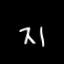

The predicted class for the image is: 지


In [11]:
from PIL import Image
from IPython.display import display, Image as IPyImage
image_path = "./image-data/font2/hangul-images/hangul_106.jpeg"
display(IPyImage(filename=image_path))
#final_prediction = predict_image_kfold(results, image_path, transform, DEVICE)
final_prediction = predict_image(model_ft, image_path, transform, DEVICE)
print(f"The predicted class for the image is: {get_label_at_index(label_file, final_prediction)}")